In [118]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.utils import resample
from lifelines import KaplanMeierFitter, statistics

In [119]:
DATA_DIR = Path("datasets/luad_tcga_gdc")
OUT_DIR    = Path("./processed"); OUT_DIR.mkdir(exist_ok=True)

TPM_FILE   = DATA_DIR / "data_mrna_seq_tpm.txt"
CNA_FILE   = DATA_DIR / "data_cna.txt"
MUT_FILE   = DATA_DIR / "data_mutations.txt"
SAMP_FILE  = DATA_DIR / "data_clinical_sample.txt"
PAT_FILE   = DATA_DIR / "data_clinical_patient.txt"

TOP_EXPR_GENES = 5000
MIN_CNA_FREQ   = 0.05
MIN_MUT_FREQ   = 0.05
PCA_VAR_TARGET = 0.90
TEST_SIZE      = 0.20
BOOT_ROUNDS    = 100

NON_SYN = {
    "Missense_Mutation","Nonsense_Mutation","Frame_Shift_Del","Frame_Shift_Ins",
    "In_Frame_Del","In_Frame_Ins","Splice_Site","Translation_Start_Site",
    "Stop_Codon_Del","Stop_Codon_Ins","Nonstop_Mutation",
}

In [120]:
def load_table(path, **kw):
    return pd.read_csv(path, sep="\t", comment="#", low_memory=False, **kw)

def mad(arr):
    med = np.median(arr)
    return np.median(np.abs(arr-med))

def tcga_sample(s):
    return isinstance(s,str) and re.fullmatch(r"TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-01A",s)


In [121]:
expr  = load_table(TPM_FILE).set_index("Entrez_Gene_Id")
cna   = load_table(CNA_FILE).set_index("Entrez_Gene_Id")
mut   = load_table(MUT_FILE)
samp  = load_table(SAMP_FILE)

In [122]:
common_ids = sorted({c for c in expr.columns if tcga_sample(c)} &
                    {c for c in cna.columns if tcga_sample(c)} &
                    {s for s in samp["SAMPLE_ID"] if tcga_sample(s)})
expr, cna = expr[common_ids], cna[common_ids]

In [123]:
expr_log2 = np.log2(expr+1)
expr_sel  = expr_log2.loc[expr_log2.apply(mad, axis=1).nlargest(TOP_EXPR_GENES).index]
expr_sel.index = expr_sel.index.astype(str)+"_expr"

In [124]:
cna_sel = cna.loc[(cna!=0).mean(axis=1)>=MIN_CNA_FREQ]
cna_sel.index = cna_sel.index.astype(str)+"_cna"

In [125]:
mut = mut[mut["Variant_Classification"].isin(NON_SYN)].copy()
if "FILTER" in mut.columns:
    mut = mut[mut["FILTER"].isin({"PASS", ".", "", np.nan})]
mut = mut[mut["Tumor_Sample_Barcode"].isin(common_ids)]
mut["val"]=1
mut_bin = mut.pivot_table(index="Entrez_Gene_Id", columns="Tumor_Sample_Barcode", values="val", aggfunc="max", fill_value=0)
mut_sel = mut_bin.loc[mut_bin.mean(axis=1)>=MIN_MUT_FREQ]
mut_sel.index = mut_sel.index.astype(str)+"_mut"

In [126]:
X = pd.concat([expr_sel, cna_sel, mut_sel]).T
X = X.loc[:, X.var()>0]
X_z = ((X - X.mean())/X.std()).fillna(0)

In [127]:
pca_full = PCA(svd_solver="randomized", random_state=0).fit(X_z)
optimal_n   = np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), PCA_VAR_TARGET)+1
pca = PCA(n_components=optimal_n, svd_solver="randomized", random_state=0)
pcs = pca.fit_transform(X_z)
print(f'⇒  {optimal_n} компонентов дают ≥ {PCA_VAR_TARGET:.0%} дисперсии')

pca_df = pd.DataFrame(pcs, index=X_z.index, columns=[f"PC{i+1}" for i in range(optimal_n)])

# save pca variance
pd.DataFrame({"PC":pca_df.columns,
              "explained":pca.explained_variance_ratio_,
              "cumulative":np.cumsum(pca.explained_variance_ratio_)}).to_csv(OUT_DIR/"luad_pca_variance.csv", index=False)

⇒  107 компонентов дают ≥ 90% дисперсии


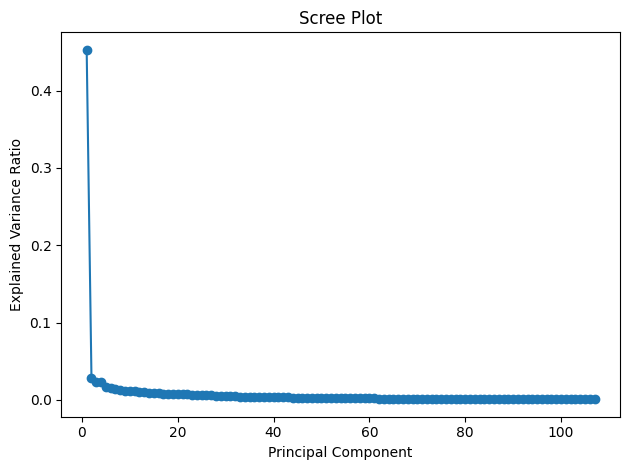

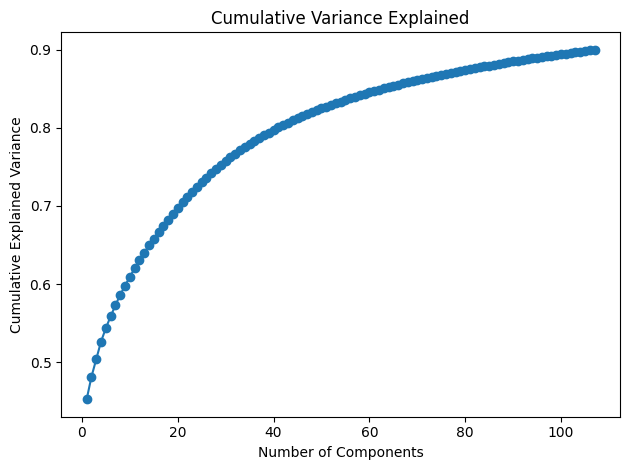

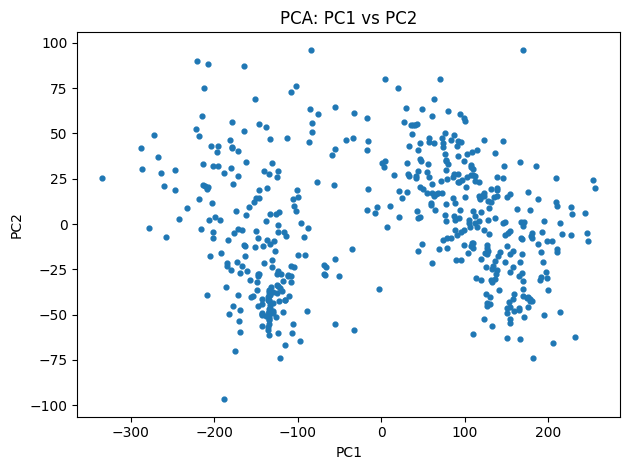

In [128]:
var_df = pd.read_csv("processed/luad_pca_variance.csv")

plt.figure()
plt.plot(var_df["PC"].str.replace("PC", "").astype(int), var_df["explained"], marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_scree.png", dpi=300)

plt.figure()
plt.plot(var_df["PC"].str.replace("PC", "").astype(int), var_df["cumulative"], marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_cumulative.png", dpi=300)

if pca_df.shape[1] >= 2:
    plt.figure()
    plt.scatter(pca_df["PC1"], pca_df["PC2"], s=12)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA: PC1 vs PC2")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "pca_pc1_pc2.png", dpi=300)

In [129]:
train_idx, test_idx = train_test_split(pca_df.index, test_size=TEST_SIZE, random_state=0)
X_train, X_test = pca_df.loc[train_idx], pca_df.loc[test_idx]

In [130]:
def eval_and_store(name, k, labels):
    if len(set(labels))<2 or len(set(labels))==len(labels):
        return
    sil = silhouette_score(X_train, labels)
    results[(name,k)] = (labels, sil)

def fit_predict(method, k, data):
    if method=="kmeans":
        return KMeans(n_clusters=k, n_init='auto', random_state=0).fit_predict(data)
    if method=="ward":
        return AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(data)
    if method=="gmm":
        return GaussianMixture(n_components=k, covariance_type="full", random_state=0).fit_predict(data)
    raise ValueError

In [131]:
results = {}

for method in ["kmeans","ward","gmm"]:
    for k in range(2,11):
        lbl = fit_predict(method,k,X_train)
        eval_and_store(method,k,lbl)

for eps in [1.0,2.0,3.0,5.0]:
    db = DBSCAN(eps=eps,min_samples=5).fit(X_train)
    if len(set(db.labels_))-(-1 in db.labels_)>=2:
        eval_and_store(f"dbscan_eps{eps}",None,db.labels_)

opt = OPTICS(min_samples=5, xi=0.05, min_cluster_size=10).fit(X_train)
if len(set(opt.labels_))-(-1 in opt.labels_)>=2:
    eval_and_store("optics",None,opt.labels_)

if not results:
    raise RuntimeError("All candidate clusterings trivial – adjust params.")

best_key,(train_labels_arr,best_sil)=max(results.items(), key=lambda x:x[1][1])
train_labels = pd.Series(train_labels_arr, index=train_idx, name="cluster")
method_best, k_best = best_key
print(f"Best (train) = {best_key}, silhouette={best_sil:.3f}")

Best (train) = ('kmeans', 2), silhouette=0.365


In [132]:
if method_best=="kmeans":
    best_model = KMeans(n_clusters=k_best, n_init='auto', random_state=0).fit(X_train)
    test_labels = best_model.predict(X_test)
elif method_best=="gmm":
    best_model = GaussianMixture(n_components=k_best,covariance_type='full',random_state=0).fit(X_train)
    test_labels = best_model.predict(X_test)
elif method_best=="ward":
    best_model = AgglomerativeClustering(n_clusters=k_best, linkage='ward')
    test_labels = best_model.fit_predict(X_test)
else:  # density models – label test separately
    best_model = None
    test_labels = None

if test_labels is not None and len(set(test_labels))>1:
    sil_test = silhouette_score(X_test, test_labels)
    print(f"Test silhouette = {sil_test:.3f}")
else:
    sil_test = np.nan

labels_full = pd.Series(index=pca_df.index, dtype=int, name="cluster")
labels_full.loc[train_idx] = train_labels.values
if test_labels is not None:
    labels_full.loc[test_idx] = test_labels
else:
    labels_full.loc[test_idx] = -1

labels_full.to_csv(OUT_DIR/"luad_clusters.csv", header=True)

Test silhouette = 0.343


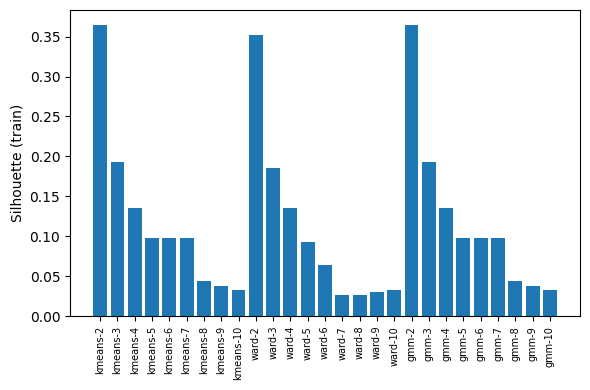

In [133]:
plt.figure(figsize=(6,4))
plt.bar([f"{k[0]}-{k[1] if k[1] else ''}" for k in results], [v[1] for v in results.values()])
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Silhouette (train)")
plt.tight_layout()
plt.savefig(OUT_DIR/"silhouette_methods.png", dpi=300)

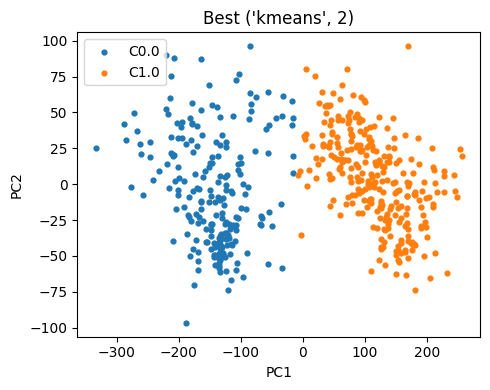

In [134]:
if "PC1" in pca_df.columns:
    plt.figure(figsize=(5,4))
    for cl in sorted(set(labels_full)):
        mask = labels_full == cl
        plt.scatter(pca_df.loc[mask,"PC1"], pca_df.loc[mask,"PC2"], s=12, label=f"C{cl}")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.title(f"Best {best_key}")
    plt.tight_layout(); plt.savefig(OUT_DIR/"pca_best_clusters.png")

/var/folders/4m/bmr6pj2s4k996yk6vfh6_1y40000gn/T/ipykernel_50235/2963632517.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ari_vals, vert=False, labels=["ARI"])


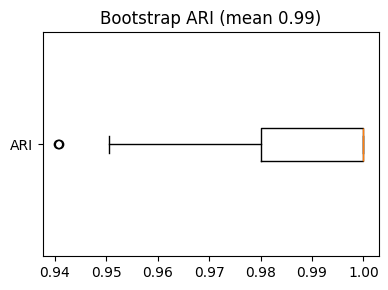

In [135]:
ari_vals=[]
for i in range(BOOT_ROUNDS):
    boot_idx = resample(train_idx, replace=True, random_state=i)
    X_b = X_train.loc[boot_idx]
    if method_best=="kmeans":
        lb = KMeans(n_clusters=k_best, n_init='auto', random_state=0).fit_predict(X_b)
    elif method_best=="gmm":
        lb = GaussianMixture(n_components=k_best,covariance_type='full',random_state=0).fit_predict(X_b)
    elif method_best=="ward":
        lb = AgglomerativeClustering(n_clusters=k_best, linkage='ward').fit_predict(X_b)
    else:
        continue
    ari_vals.append(adjusted_rand_score(train_labels.loc[boot_idx], lb))

if ari_vals:
    pd.Series(ari_vals, name="ARI").to_csv(OUT_DIR/"cluster_stability_bootstrap.csv", index=False)
    plt.figure(figsize=(4,3))
    plt.boxplot(ari_vals, vert=False, labels=["ARI"])
    plt.title(f"Bootstrap ARI (mean {np.mean(ari_vals):.2f})")
    plt.tight_layout(); plt.savefig(OUT_DIR/"bootstrap_ari.png", dpi=300)

pca_df.to_csv(OUT_DIR/"luad_pca_scores.csv")

In [136]:
url = "https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz"
gene_map = (
    pd.read_csv(
        url,
        sep="	",
        compression="gzip",
        comment="#",
        header=None,
        usecols=[1, 2],
        names=["GeneID", "Symbol"],
    )
    .set_index("GeneID")["Symbol"]
)

for c in sorted(labels_full.unique()):
    mask = labels_full == c
    freq = mut_bin.loc[:, mask].mean(axis=1)
    df_freq = (
        pd.DataFrame({
            "Entrez_Gene_Id": freq.index,
            "HUGO_Symbol": freq.index.map(lambda x: gene_map.get(x, "?")),
            "Frequency": freq.values,
        })
        .sort_values("Frequency", ascending=False)
    )

    top_df = df_freq.head(10)
    top_df.index = top_df.apply(lambda r: f"{r['HUGO_Symbol']} ({int(r['Entrez_Gene_Id'])})", axis=1)
    print(f"Cluster {c} top genes:")
    print(top_df["Frequency"], end="\n\n")

Cluster 0.0 top genes:
TP53 (7157)       0.386047
MUC16 (94025)     0.306977
TTN (7273)        0.279070
CSMD3 (114788)    0.274419
RYR2 (6262)       0.269767
KRAS (3845)       0.255814
LRP1B (53353)     0.251163
ZFHX4 (79776)     0.213953
FLG (2312)        0.186047
USH2A (7399)      0.186047
Name: Frequency, dtype: float64

Cluster 1.0 top genes:
TP53 (7157)       0.565217
TTN (7273)        0.554348
CSMD3 (114788)    0.463768
MUC16 (94025)     0.463768
RYR2 (6262)       0.398551
USH2A (7399)      0.387681
ZFHX4 (79776)     0.373188
LRP1B (53353)     0.369565
KRAS (3845)       0.297101
XIRP2 (129446)    0.271739
Name: Frequency, dtype: float64



In [137]:
samp = load_table(SAMP_FILE).set_index("SAMPLE_ID")
pat  = load_table(PAT_FILE).set_index("PATIENT_ID")

clusters = pd.Series(labels_full, index=pca_df.index, name="cluster")

samp["cluster"] = clusters
samp = samp.dropna(subset=["cluster"])

pat["cluster"] = (
    samp.groupby("PATIENT_ID")["cluster"]
        .first()# или .mode().iloc[0]
)

pat = pat.dropna(subset=["cluster"])
pat["cluster"] = pat["cluster"]

# ---------- survival columns ----------
time = pat["OS_MONTHS"]
event = pat["OS_STATUS"].str.startswith("1").astype(int)

# убрать нули / NaN
valid = time.notna() & (time > 0)
pat = pat[valid]
time = time[valid]
event = event[valid]

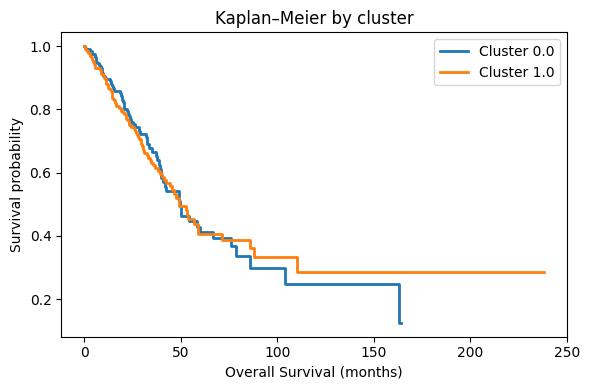

In [138]:
time = pat["OS_MONTHS"]
event = pat["OS_STATUS"].astype(str).str.startswith("1").astype(int)
valid = time.notna() & (time > 0)
clin_pat = pat[valid]
time = time[valid]
event = event[valid]

plt.figure(figsize=(6, 4))
ax = plt.gca()
km = KaplanMeierFitter()
summary_rows = []

for c in sorted(pat["cluster"].unique()):
    m = pat["cluster"] == c
    km.fit(time[m], event[m], label=f"Cluster {c}")
    km.plot(ax=ax, ci_show=False, linewidth=2)
    summary_rows.append({
        "cluster": int(c),
        "n": int(m.sum()),
        "median_OS_months": km.median_survival_time_
    })

ax.set_xlabel("Overall Survival (months)")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier by cluster")
plt.tight_layout()
plt.savefig(OUT_DIR / "km_clusters.png", dpi=300)

In [140]:
# log-rank if 2 clusters
clusters_present = sorted(pat["cluster"].unique())
p_val = np.nan

c0, c1 = clusters_present
res = statistics.logrank_test(
    time[pat.cluster == c0],
    time[pat.cluster == c1],
    event_observed_A=event[pat.cluster == c0],
    event_observed_B=event[pat.cluster == c1],
)
p_val = res.p_value
print(f"Log-rank p-value (Cluster {c0} vs {c1}) = {p_val:.4f}")


pd.DataFrame(summary_rows).assign(logrank_p=p_val).to_csv(OUT_DIR / "cluster_survival_summary.csv", index=False)

Log-rank p-value (Cluster 0.0 vs 1.0) = 0.8399
